In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [ ]:
# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('train_FD001.txt',sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt',sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

In [ ]:
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
test.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


Now we will calculated and add RUL(Remaining Useful Life) to the train dataset.

RUL = Max Life Time Cycle of Engine-Current Time Cycle

Max Life Time Cycle of Engine means time when engine has degraded.

In [ ]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life

    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
train = add_remaining_useful_life(train)
train[sensor_names+['RUL']].head()

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [ ]:
train.describe()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000


In [ ]:
train=train.drop(['setting_3','s_1','s_10','s_18','s_19'],axis=1)
test=test[train.columns.drop('RUL')]

In [ ]:
for i in train.columns:
    print(f'The number of null values present in {i} is {train[i].isna().sum()} ')

The number of null values present in unit_nr is 0 
The number of null values present in time_cycles is 0 
The number of null values present in setting_1 is 0 
The number of null values present in setting_2 is 0 
The number of null values present in s_2 is 0 
The number of null values present in s_3 is 0 
The number of null values present in s_4 is 0 
The number of null values present in s_5 is 0 
The number of null values present in s_6 is 0 
The number of null values present in s_7 is 0 
The number of null values present in s_8 is 0 
The number of null values present in s_9 is 0 
The number of null values present in s_11 is 0 
The number of null values present in s_12 is 0 
The number of null values present in s_13 is 0 
The number of null values present in s_14 is 0 
The number of null values present in s_15 is 0 
The number of null values present in s_16 is 0 
The number of null values present in s_17 is 0 
The number of null values present in s_20 is 0 
The number of null values pr

In [ ]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

In [ ]:
print(f'The shape of the training data : {train.shape}')
print(f'The shape of the testing data : {test.shape}')

The shape of the training data : (20631, 22)
The shape of the testing data : (13096, 21)


In [ ]:
print(f"Let's see how much time cycles does each engine revolves",end="\n")
time_cycle_each = []
for i in range(1,101):
    print(f"Engine {i} revolves : {len(train.time_cycles[train['unit_nr']==i])} cycles")
    time_cycle_each.append(len(train.time_cycles[train['unit_nr']==i]))

Let's see how much time cycles does each engine revolves
Engine 1 revolves : 192 cycles
Engine 2 revolves : 287 cycles
Engine 3 revolves : 179 cycles
Engine 4 revolves : 189 cycles
Engine 5 revolves : 269 cycles
Engine 6 revolves : 188 cycles
Engine 7 revolves : 259 cycles
Engine 8 revolves : 150 cycles
Engine 9 revolves : 201 cycles
Engine 10 revolves : 222 cycles
Engine 11 revolves : 240 cycles
Engine 12 revolves : 170 cycles
Engine 13 revolves : 163 cycles
Engine 14 revolves : 180 cycles
Engine 15 revolves : 207 cycles
Engine 16 revolves : 209 cycles
Engine 17 revolves : 276 cycles
Engine 18 revolves : 195 cycles
Engine 19 revolves : 158 cycles
Engine 20 revolves : 234 cycles
Engine 21 revolves : 195 cycles
Engine 22 revolves : 202 cycles
Engine 23 revolves : 168 cycles
Engine 24 revolves : 147 cycles
Engine 25 revolves : 230 cycles
Engine 26 revolves : 199 cycles
Engine 27 revolves : 156 cycles
Engine 28 revolves : 165 cycles
Engine 29 revolves : 163 cycles
Engine 30 revolves : 194

In [ ]:
#The same time cycle that each engine revolves for the testing data
time_cycle_each_test = []
for i in range(1,101):
    time_cycle_each_test.append(len(test.time_cycles[test['unit_nr']==i]))

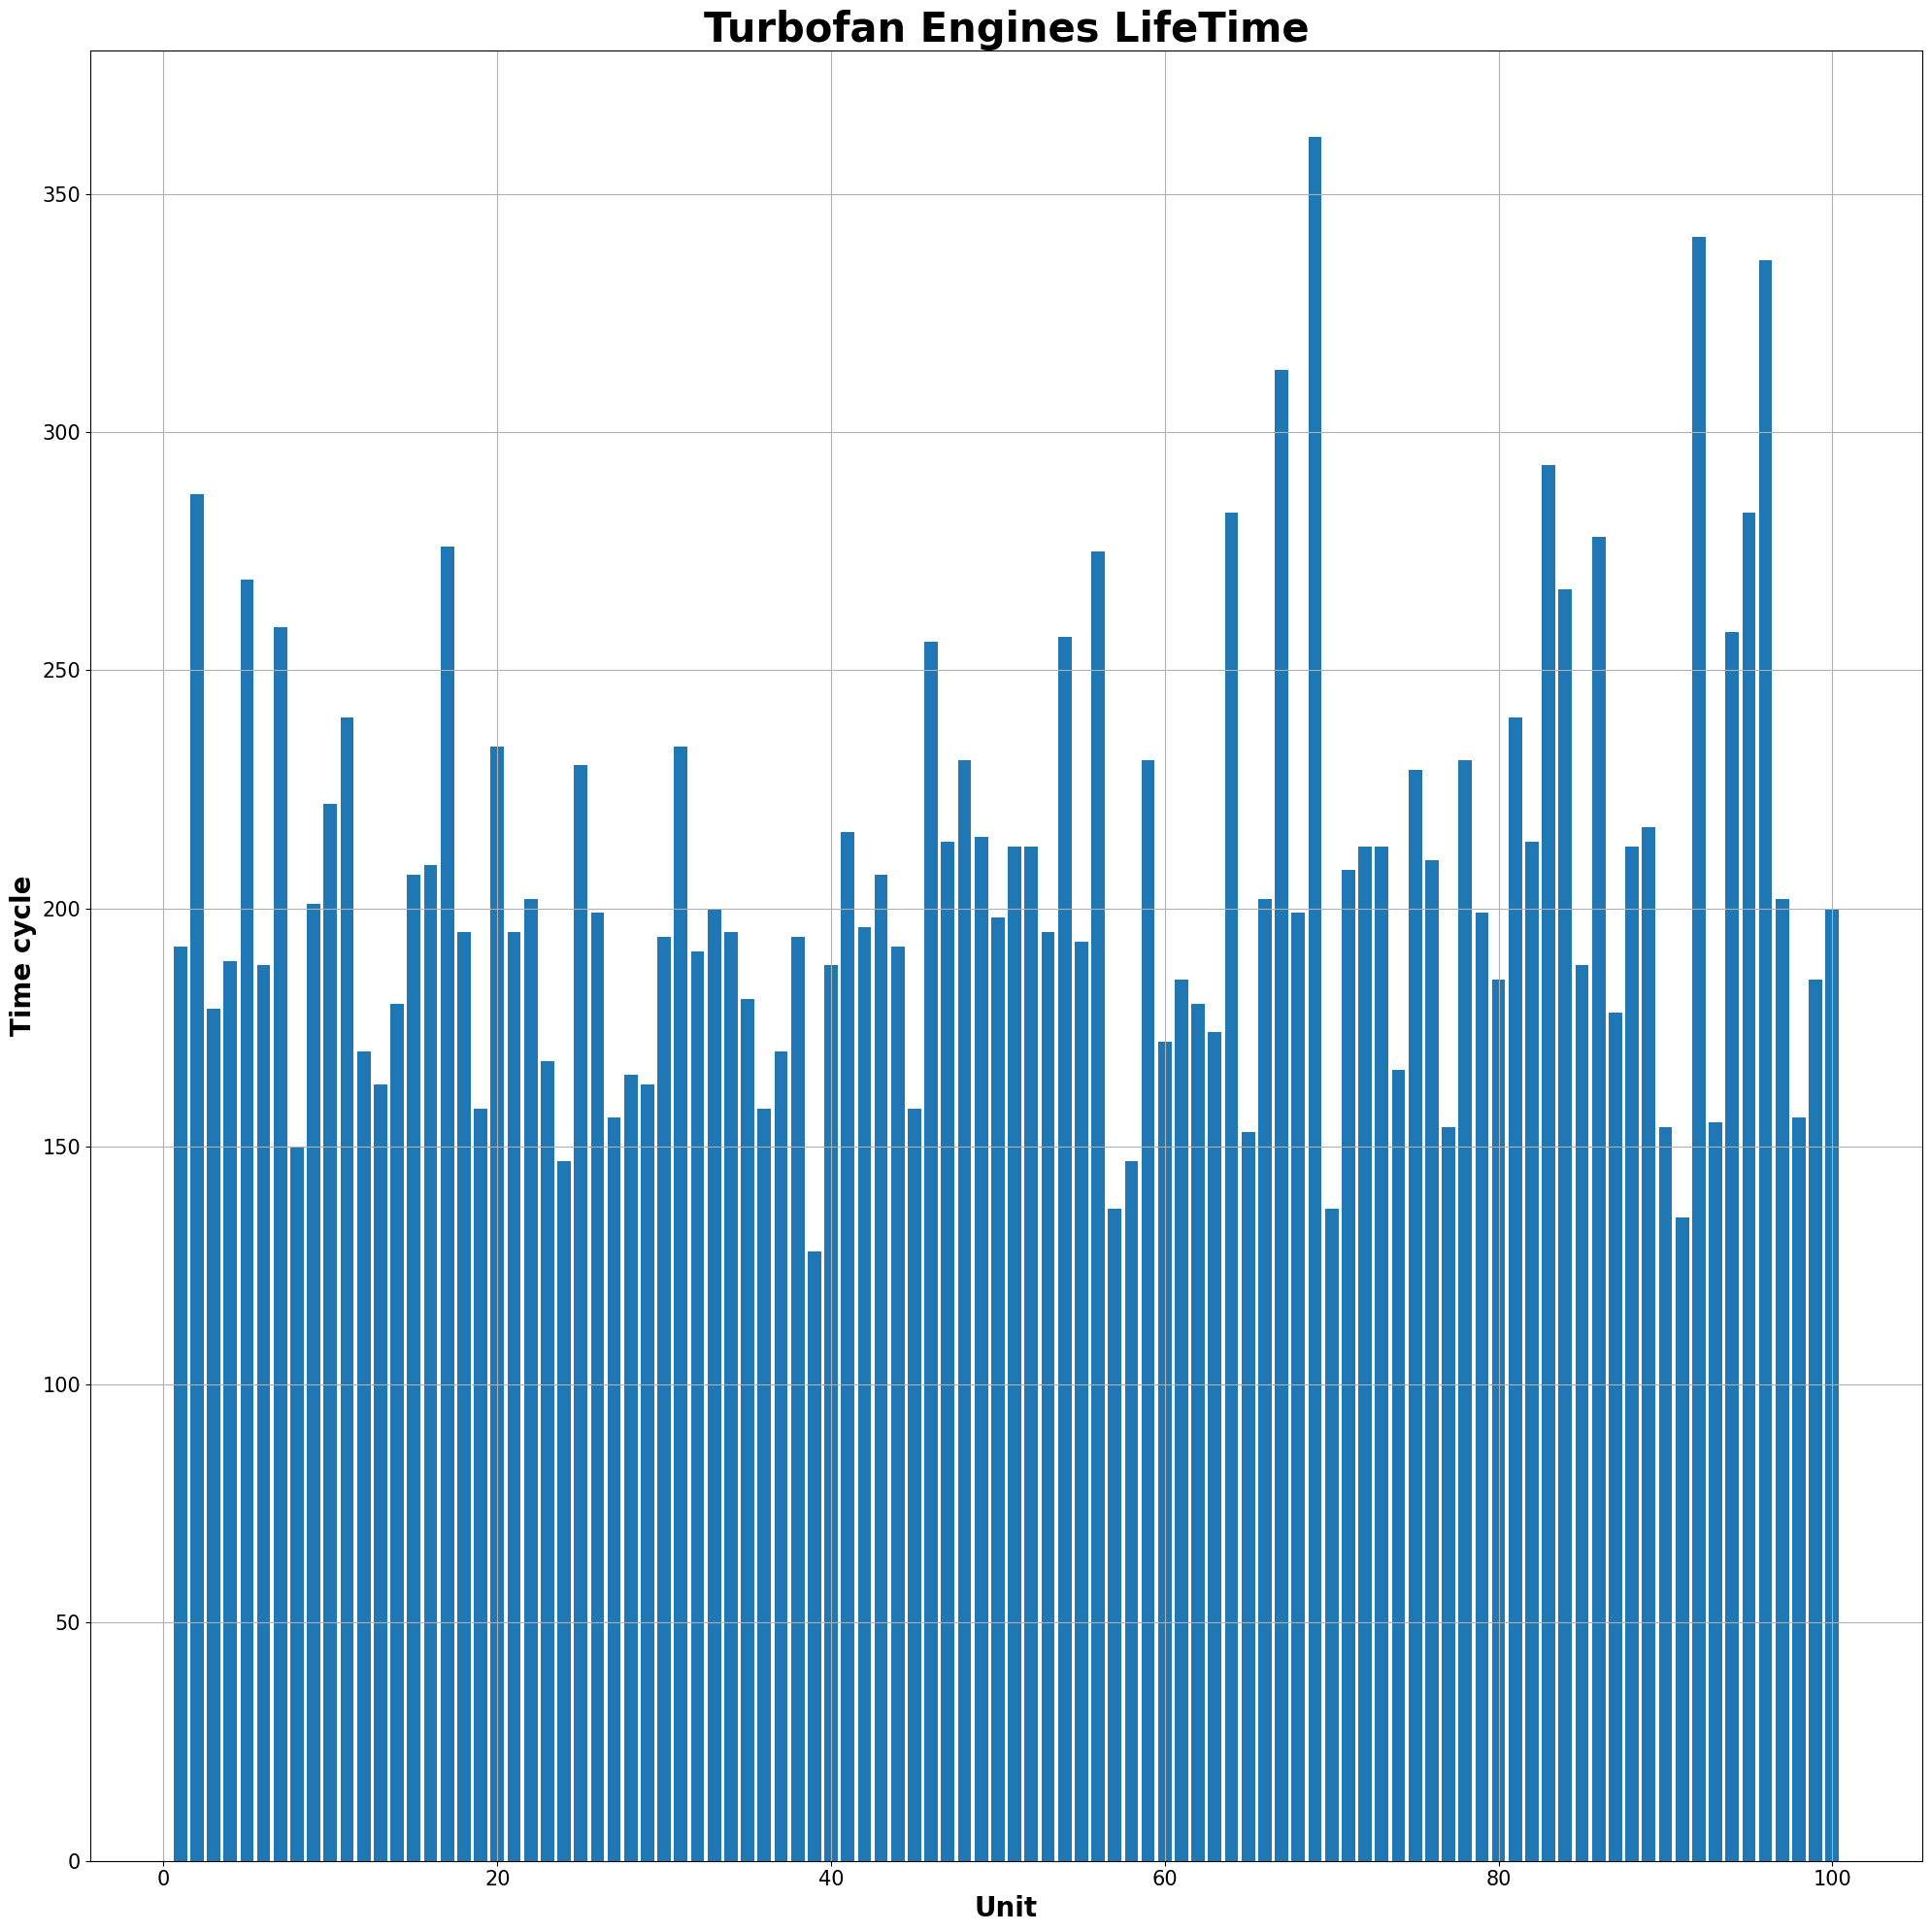

In [ ]:
#Turbofan engines life time
plt.figure(figsize=(20,20))
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.bar(train.unit_nr.unique(),time_cycle_each)
plt.xlabel('Unit',fontweight='bold',size=20)
plt.ylabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.savefig('Turbofan Engines LifeTime.png')
plt.show()

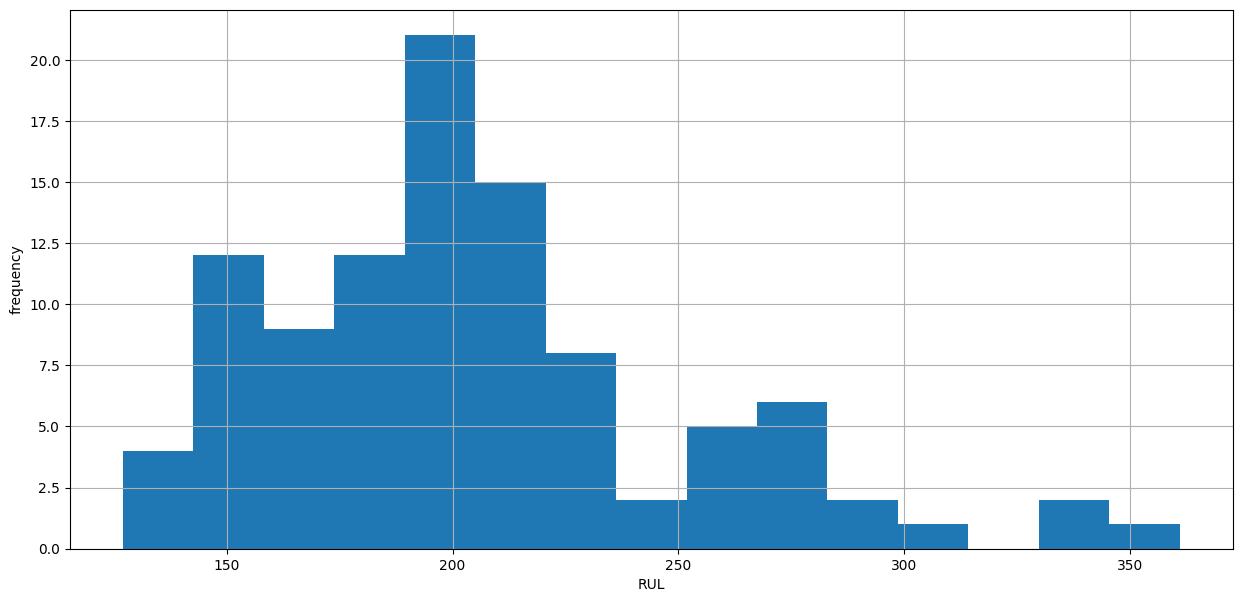

In [ ]:
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

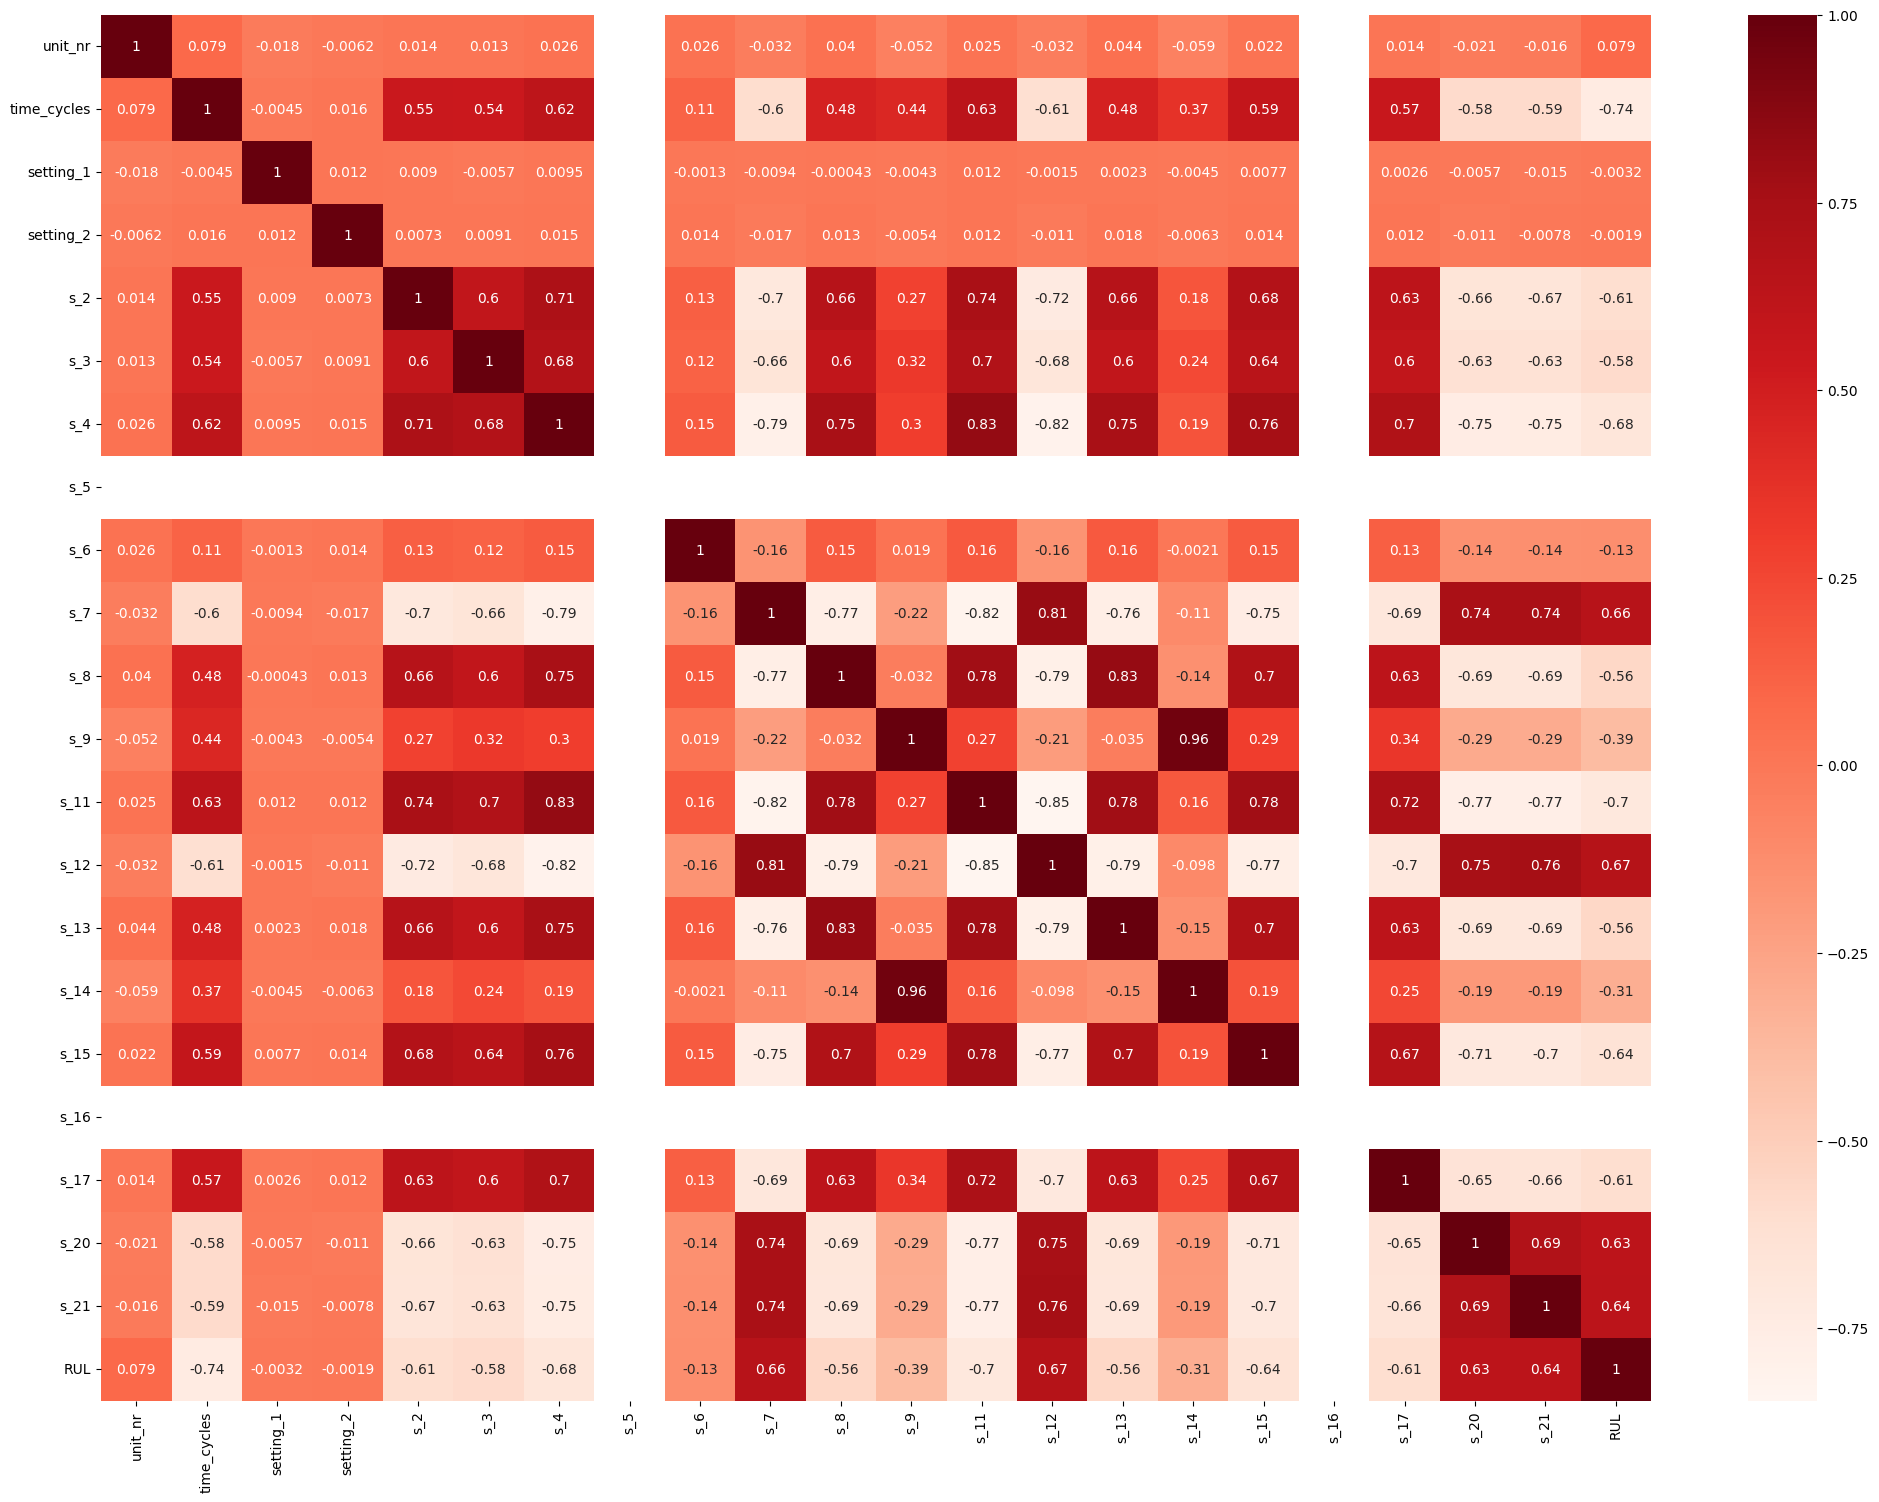

In [ ]:
plt.figure(figsize=(25,18))
sns.heatmap(train.corr(),annot=True ,cmap='Reds')
plt.show()

In [ ]:
cor=train.corr()
#Selecting highly correlated features
train_relevant_features = cor[abs(cor['RUL'])>=0.5]
train_relevant_features['RUL']

,RUL
time_cycles,-0.736241
s_2,-0.606484
s_3,-0.584520
s_4,-0.678948
s_7,0.657223
s_8,-0.563968
s_11,-0.696228
s_12,0.671983
s_13,-0.562569
s_15,-0.642667


In [ ]:
list_relevant_features=train_relevant_features.index
list_relevant_features=list_relevant_features[1:]
list_relevant_features

Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_11', 's_12', 's_13', 's_15',
       's_17', 's_20', 's_21', 'RUL'],
      dtype='object')

In [ ]:
final_train_data = train[list_relevant_features]
final_test_data = test[list_relevant_features.drop('RUL')]

In [ ]:
X_train=final_train_data.drop('RUL',axis=1)
y_train=final_train_data[['RUL']]

In [ ]:
X_test=final_test_data[X_train.columns]
X_test.head()

,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21
0,643.02,1585.29,1398.21,553.90,2388.04,47.20,521.72,2388.03,8.4052,392,38.86,23.3735
1,641.71,1588.45,1395.42,554.85,2388.01,47.50,522.16,2388.06,8.3803,393,39.02,23.3916
2,642.46,1586.94,1401.34,554.11,2388.05,47.50,521.97,2388.03,8.4441,393,39.08,23.4166
3,642.44,1584.12,1406.42,554.07,2388.03,47.28,521.38,2388.05,8.3917,391,39.00,23.3737
4,642.51,1587.19,1401.92,554.16,2388.01,47.31,522.15,2388.03,8.4031,390,38.99,23.4130


In [ ]:
y_test = pd.DataFrame({'RUL': np.repeat(y_test['RUL'], time_cycle_each_test)})
y_test.set_index(i for i in range(13096))

,RUL
0,112
1,112
2,112
3,112
4,112
...,...
13091,20
13092,20
13093,20
13094,20


In [ ]:
print(f'The shape of the training data : {X_train.shape} , {y_train.shape}')
print(f'The shape of the testing data : {X_test.shape} , {y_test.shape}')

The shape of the training data : (20631, 12) , (20631, 1)
The shape of the testing data : (13096, 12) , (13096, 1)


In [ ]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse,variance;

Model 1: Linear Regression

In [ ]:
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train)
X_test1 = sc.transform(X_test)
# create and fit model
lm = LinearRegression()
lm.fit(X_train1, y_train)
# predict and evaluate
y_hat_train1 = lm.predict(X_train1)
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1,'train')
y_hat_test1 = lm.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1,'test')

train set RMSE:45.61466077800371, R2:0.5614378099126991
test set RMSE:83.62071904183514, R2:-3.082084657446388


In [ ]:
# Make Dataframe which will contain results of all applied Model
Results=pd.DataFrame({'Model':['LR'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]})
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,45.614661,0.561438,83.620719,-3.082085


Actual Vs Predicted RUL

In [ ]:
# Function to plot Actual vs Predicted RUL
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(10,6))
    plt.plot(y_true.values, label="Actual", color="blue", linewidth=2.5)
    plt.plot(y_pred, label="Predicted", color="red", linestyle="--", linewidth=2.5)
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()

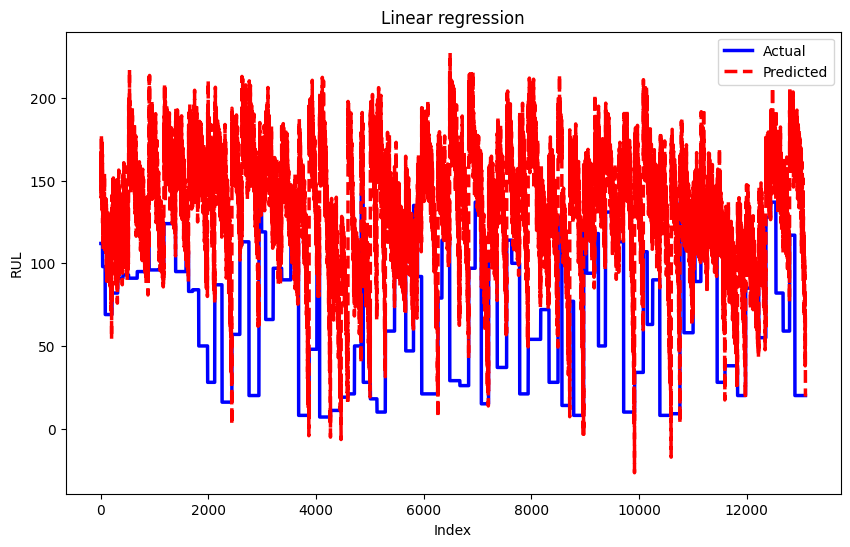

In [ ]:
# Plot for linear regression
plot_actual_vs_predicted(y_test, y_hat_test1, "Linear regression")

Ridge - Train set RMSE:45.61466080921889, R2:0.5614378093124623
Ridge - Test set RMSE:83.6203471974691, R2:-3.0820483531231515


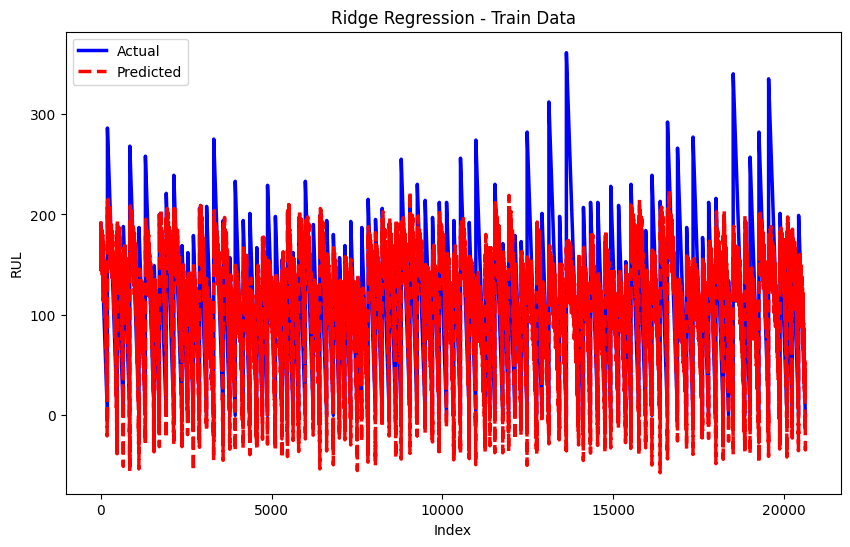

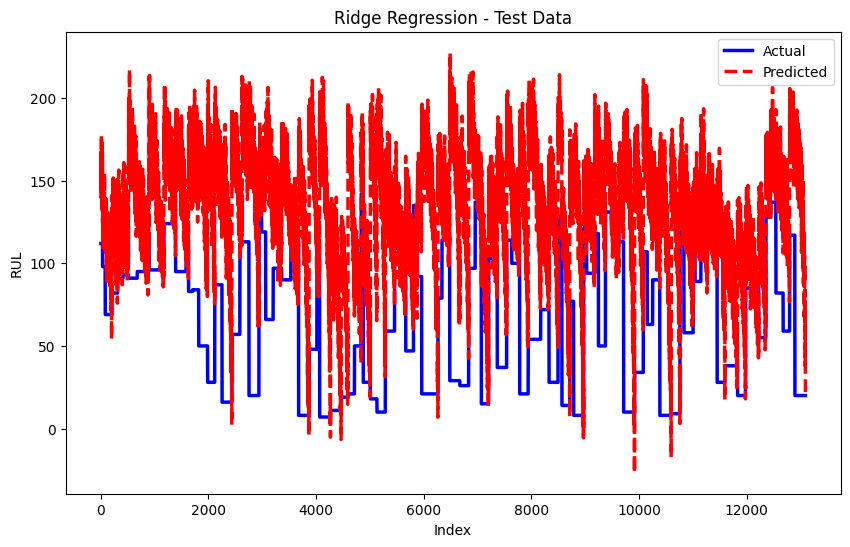

In [ ]:
# Applying Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train1, y_train)
y_train_ridge_pred = ridge.predict(X_train1)
y_test_ridge_pred = ridge.predict(X_test1)

# Evaluate Ridge Regression model
rmse_train_ridge, r2_train_ridge = evaluate(y_train, y_train_ridge_pred, label="Ridge - Train")
rmse_test_ridge, r2_test_ridge = evaluate(y_test, y_test_ridge_pred, label="Ridge - Test")

# Plot Actual vs Predicted for Ridge Regression (Train and Test)
plot_actual_vs_predicted(y_train, y_train_ridge_pred, "Ridge Regression - Train Data")
plot_actual_vs_predicted(y_test, y_test_ridge_pred, "Ridge Regression - Test Data")


Lasso - Train set RMSE:45.616617249179434, R2:0.5614001881187352
Lasso - Test set RMSE:83.52237743017207, R2:-3.0724888841978775


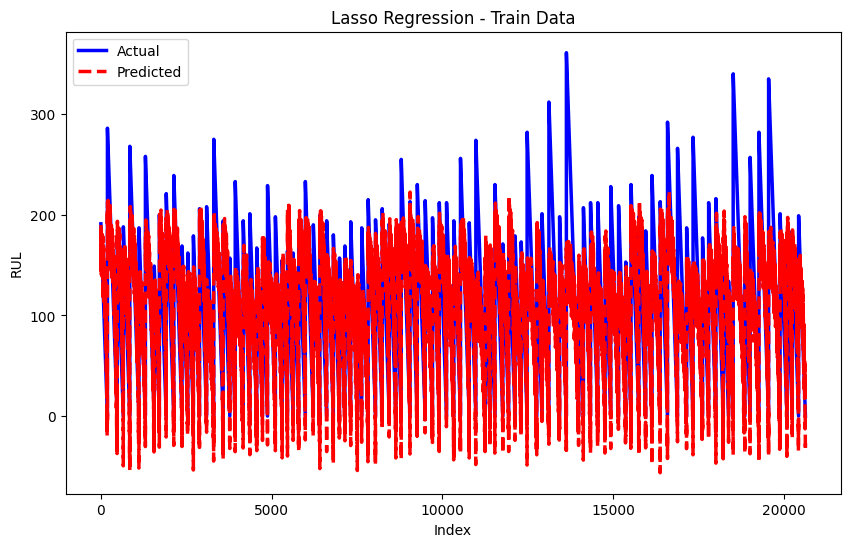

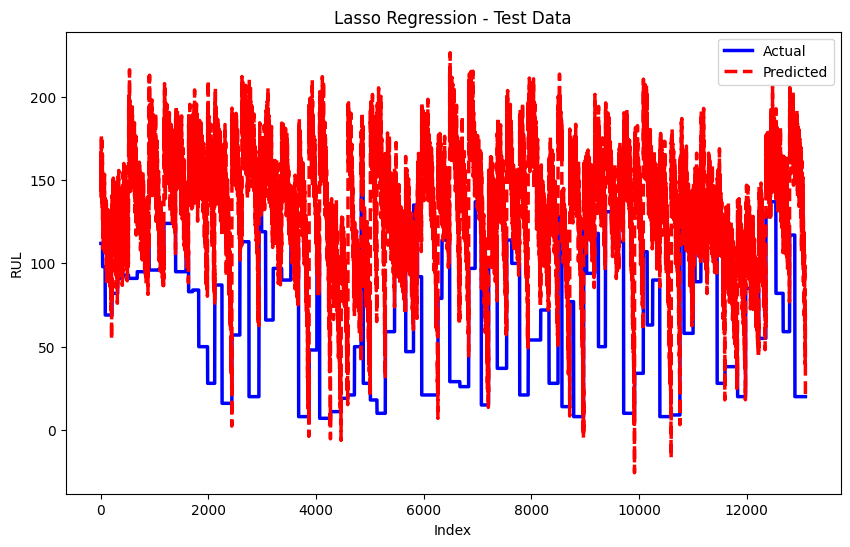

In [ ]:
# Applying Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train1, y_train)
y_train_lasso_pred = lasso.predict(X_train1)
y_test_lasso_pred = lasso.predict(X_test1)

# Evaluate Lasso Regression model
rmse_train_lasso, r2_train_lasso = evaluate(y_train, y_train_lasso_pred, label="Lasso - Train")
rmse_test_lasso, r2_test_lasso = evaluate(y_test, y_test_lasso_pred, label="Lasso - Test")

# Plot Actual vs Predicted for Lasso Regression (Train and Test)
plot_actual_vs_predicted(y_train, y_train_lasso_pred, "Lasso Regression - Train Data")
plot_actual_vs_predicted(y_test, y_test_lasso_pred, "Lasso Regression - Test Data")


In [ ]:
# Append results to DataFrame for comparison
Results = pd.concat([Results, pd.DataFrame({
    'Model': ['Ridge', 'Lasso'],
    'RMSE-Train': [rmse_train_ridge, rmse_train_lasso],
    'R2-Train': [r2_train_ridge, r2_train_lasso],
    'RMSE-Test': [rmse_test_ridge, rmse_test_lasso],
    'R2-Test': [r2_test_ridge, r2_test_lasso]
})], ignore_index=True)

# Display Results DataFrame
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,45.614661,0.561438,83.620719,-3.082085
1,Ridge,45.614661,0.561438,83.620347,-3.082048
2,Lasso,45.616617,0.561400,83.522377,-3.072489


Model 2: Random Forest



In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=6, min_samples_leaf=5)
rf.fit(X_train1, y_train)
y_hat_train1 = rf.predict(X_train1)
# Evaluating on Train Data Set
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')
# Evaluating on Test Data Set
y_hat_test1 = rf.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)
# Make Dataframe which will contain results of all applied Model
Results = pd.concat([Results, pd.DataFrame({'Model':['RF'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]})], ignore_index=True)
Results

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


train set RMSE:44.793331149655884, R2:0.5770889724209527
test set RMSE:82.39051253037219, R2:-2.9628590058224016


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,45.614661,0.561438,83.620719,-3.082085
1,Ridge,45.614661,0.561438,83.620347,-3.082048
2,Lasso,45.616617,0.561400,83.522377,-3.072489
3,RF,44.793331,0.577089,82.390513,-2.962859


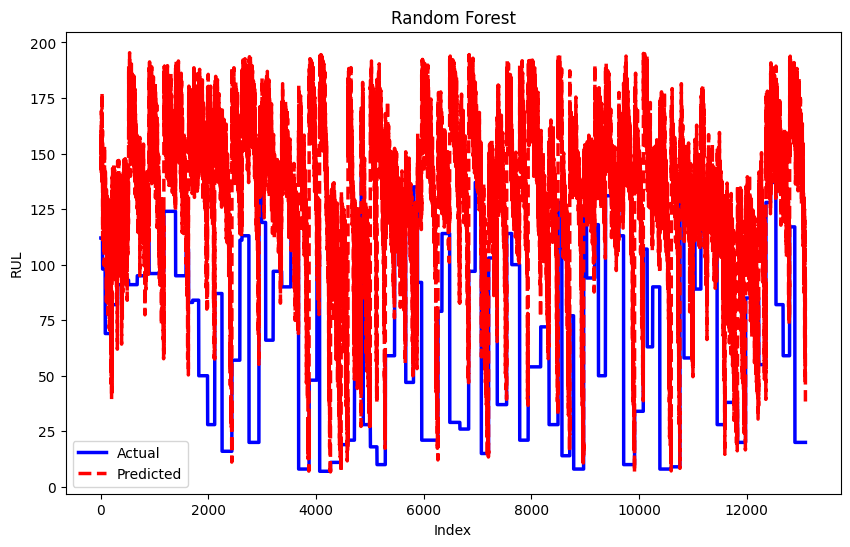

In [ ]:
# Plot for Random Forest
plot_actual_vs_predicted(y_test, y_hat_test1, "Random Forest")

In [ ]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf.feature_importances_})
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
5,s_11,0.761532
2,s_4,0.136616
8,s_15,0.021893
6,s_12,0.017051
3,s_7,0.016381
11,s_21,0.015377
1,s_3,0.008132
10,s_20,0.007694
0,s_2,0.006523
9,s_17,0.005368


Hyperparameter Tuning using Grid Search

In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
# Create the parameter grid based on the results of random search
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4,5,6],
    'n_estimators': [10, 30, 50, 100]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=params,
                          cv=4, n_jobs=-1, verbose=1)

grid_search.fit(X_train1, y_train)

Fitting 4 folds for each of 500 candidates, totalling 2000 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                         'max_features': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100]},
             verbose=1)

In [ ]:
rf_best = grid_search.best_estimator_
y_hat_train = rf_best.predict(X_train1)
# Evaluating on Train Data Set
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')
# Evaluating on Test Data Set
y_hat_test1 = rf_best.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)
# Make Dataframe which will contain results of all applied Model
Results = pd.concat([Results, pd.DataFrame({'Model':['RF with tuning'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]})], ignore_index=True)
Results

train set RMSE:44.793331149655884, R2:0.5770889724209527
test set RMSE:82.87545511276637, R2:-3.0096463036489167


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,45.614661,0.561438,83.620719,-3.082085
1,Ridge,45.614661,0.561438,83.620347,-3.082048
2,Lasso,45.616617,0.561400,83.522377,-3.072489
3,RF,44.793331,0.577089,82.390513,-2.962859
4,RF with tuning,44.793331,0.577089,82.875455,-3.009646


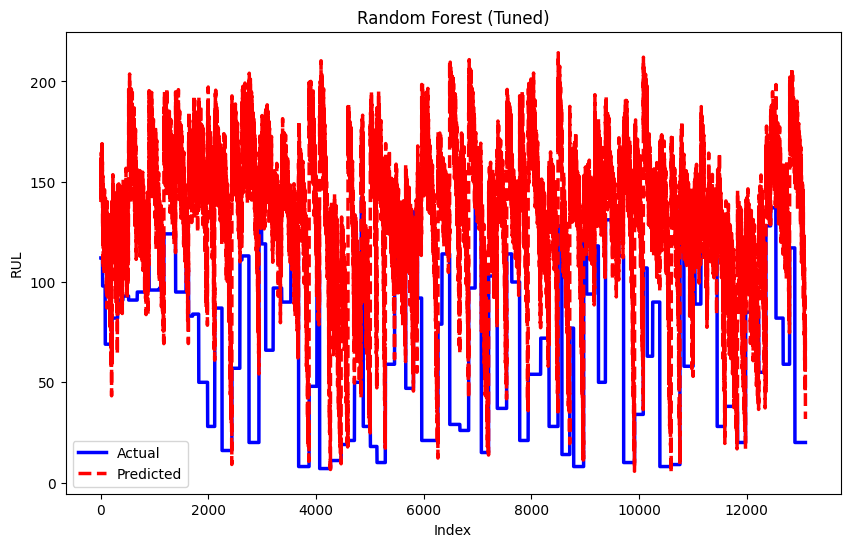

In [ ]:
# Plot for Random Forest with Tuning
plot_actual_vs_predicted(y_test, y_hat_test1, "Random Forest (Tuned)")

Model 3: XG Boost Algorithm

In [ ]:
xgb_r = xgb.XGBRegressor()
xgb_r.fit(X_train1, y_train)
# Evaluating on Train Data Set
y_hat_train1 = xgb_r.predict(X_train1)
# Evaluating on Train Data Set
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')
# Evaluating on Test Data Set
y_hat_test1 = xgb_r.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)
# Make Dataframe which will contain results of all applied Model
Results = pd.concat([Results, pd.DataFrame({'Model':['XGBoost'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]})], ignore_index=True)
Results

train set RMSE:32.327390733549635, R2:0.7797258496284485
test set RMSE:85.18919172337394, R2:-3.2366561889648438


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,LR,45.614661,0.561438,83.620719,-3.082085
1,Ridge,45.614661,0.561438,83.620347,-3.082048
2,Lasso,45.616617,0.561400,83.522377,-3.072489
3,RF,44.793331,0.577089,82.390513,-2.962859
4,RF with tuning,44.793331,0.577089,82.875455,-3.009646
5,XGBoost,32.327391,0.779726,85.189192,-3.236656


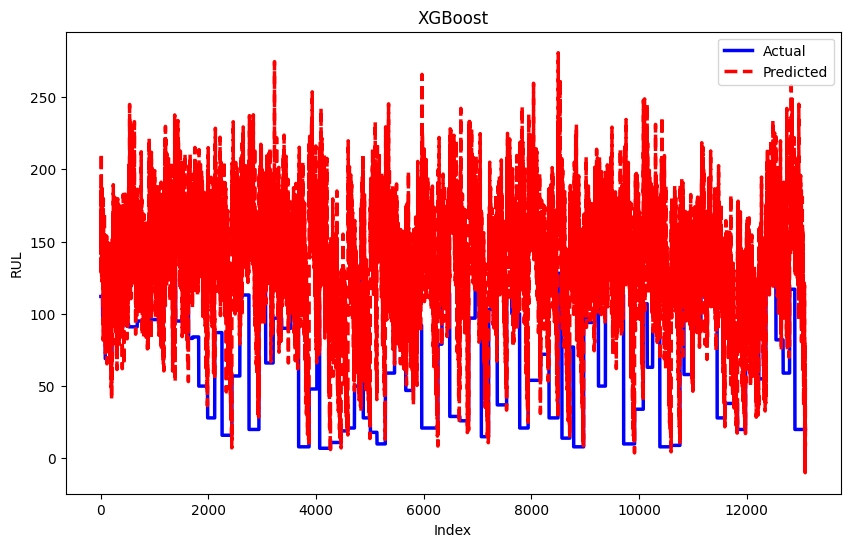

In [ ]:
# Plot for XGBoost
plot_actual_vs_predicted(y_test, y_hat_test1, "XGBoost")